### Data loading

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

In [55]:
import os
from PIL import Image
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
from torchvision.utils import save_image

import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

### Часть 1. Перенос стиля при помощи pix2pix

В этом задании требуется реализовывать перенос стиля на спаренных данных (paired data) для датасета, состоящего из масок и фото фасадов домов.
Подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля.

based on Pix2Pix explained with code

Dataloader

In [18]:
class FacadesDataset(Dataset):
    def __init__(self, fpath, target_size=None):
        self.filenames = [os.path.join(fpath, f) for f in os.listdir(fpath) if f.endswith(".jpg")]
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        img = image[:, :, : image_width // 2]
        mask = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(mask, size=target_size)
            real = nn.functional.interpolate(img, size=target_size)

        return real, condition

In [7]:
class ConvDownsample(nn.Module):
    """
    Layer size decrease
    """
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):

        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [8]:
class ConvUpsample(nn.Module):
    """
    Layer size increase
    """
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True, dropout=False):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [9]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.encoders = [
            ConvDownsample(in_channels, 64, batchnorm=False),  # batch_size x 64 x 128 x 128
            ConvDownsample(64, 128),  # batch_size x 128 x 64 x 64
            ConvDownsample(128, 256),  # batch_size x 256 x 32 x 32
            ConvDownsample(256, 512),  # batch_size x 512 x 16 x 16
            ConvDownsample(512, 512),  # batch_size x 512 x 8 x 8
            ConvDownsample(512, 512),  # batch_size x 512 x 4 x 4
            ConvDownsample(512, 512),  # batch_size x 512 x 2 x 2
            ConvDownsample(512, 512, batchnorm=False),  # batch_size x 512 x 1 x 1
        ]
      
        self.decoders = [
            ConvUpsample(512, 512, dropout=True),  # batch_size x 512 x 2 x 2
            ConvUpsample(1024, 512, dropout=True),  # batch_size x 512 x 4 x 4
            ConvUpsample(1024, 512, dropout=True),  # batch_size x 512 x 8 x 8
            ConvUpsample(1024, 512),  # batch_size x 512 x 16 x 16
            ConvUpsample(1024, 256),  # batch_size x 256 x 32 x 32
            ConvUpsample(512, 128),  # batch_size x 128 x 64 x 64
            ConvUpsample(256, 64),  # batch_size x 64 x 128 x 128
        ]

        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]

        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        x = self.final_conv(x)
        return self.tanh(x)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = ConvDownsample(input_channels, 64, batchnorm=False)
        self.d2 = ConvDownsample(64, 128)
        self.d3 = ConvDownsample(128, 256)
        self.d4 = ConvDownsample(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [11]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, 0)

In [26]:
class Pix2Pix(nn.Module):

    def __init__(self, in_channels, out_channels, learning_rate=1e-3, lambda_recon=200):

        super().__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.generator = Generator(in_channels, out_channels)
        self.discriminator = Discriminator(in_channels + out_channels)

        # intializing weights
        self.generator = self.generator.apply(weights_init)
        self.discriminator = self.discriminator.apply(weights_init)

        self.generator = self.generator.to(self.device)
        self.discriminator = self.discriminator.to(self.device)


        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.reconstruction_criterion = nn.L1Loss()

        self.lambda_ = lambda_recon

        self.gen_optim = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.disc_optim = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)


    def _gen_step(self, real_images, conditioned_images):
        fake_images = self.generator(conditioned_images)
        disc_logits = self.discriminator(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))
        reconstruction_loss = self.reconstruction_criterion(fake_images, real_images)

        return adversarial_loss + self.lambda_ * reconstruction_loss, fake_images

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.generator(conditioned_images).detach()
        fake_logits = self.discriminator(fake_images, conditioned_images)

        real_logits = self.discriminator(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def train_epoch(self, batch, batch_idx=0, optimizer_idx=0):
        real, condition = batch
        real, condition =  real.to(self.device), condition.to(self.device)
      
        disc_loss = self._disc_step(real, condition)
        self.disc_optim.zero_grad()
        disc_loss.backward()
        self.disc_optim.step()
        
        gen_loss, imgs = self._gen_step(real, condition)
        self.gen_optim.zero_grad()
        gen_loss.backward()
        self.gen_optim.step()
      
        return disc_loss.cpu().detach().numpy(), gen_loss.cpu().detach().numpy(), imgs

    def unload(self):
        self.generator = self.generator.to("cpu")
        self.discriminator = self.discriminator.to("cpu")

Training

In [50]:
num_epochs = 100
batch_size = 32
lr = 1e-3
target_size = 256

In [51]:
dataset = FacadesDataset(fpath = r"/content/facades/train", target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
pix2pix = Pix2Pix(3, 3, learning_rate=lr)

In [53]:
t_epochs = trange(num_epochs, desc='Epoch', leave=True)

_disc_loss, _gen_loss = [], []
for epoch in t_epochs:
    for batch in dataloader:
        loss_disc, loss_gen, imgs = pix2pix.train_epoch(batch)
        _disc_loss.append(loss_disc)
        _gen_loss.append(loss_gen)
        t_epochs.set_description("Epoch {}: Loss discriminator {:.5f}; Loss generator {:.5f}".format(epoch, loss_disc, loss_gen ))
        if epoch % 10 == 0:
          save_image(imgs[0].cpu(), f"epoch_{epoch}.png")

_disc_loss = np.array(_disc_loss)
_gen_loss = np.array(_gen_loss)

Epoch 99: Loss discriminator 0.39040; Loss generator 22.97400: 100%|██████████| 100/100 [14:35<00:00,  8.76s/it]


In [54]:
torch.save(pix2pix.generator, "generator.pkl")
torch.save(pix2pix.discriminator, "discriminator.pkl")

In [78]:
# np.savetxt('gen_loss.txt', _gen_loss, delimiter=',')
# np.savetxt('disc_loss.txt', _disc_loss, delimiter=',')

Text(0.5, 1.0, 'Discriminator loss')

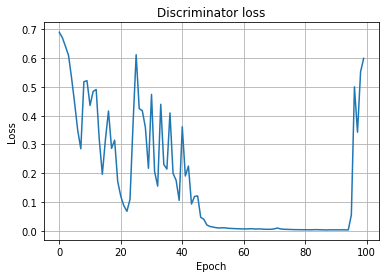

In [74]:
plt.figure()
plt.plot(np.mean(_disc_loss.reshape(-1, len(dataloader)), axis=1))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator loss")

Text(0.5, 1.0, 'Generator loss')

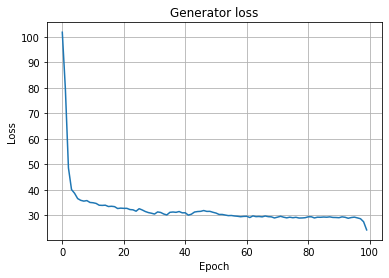

In [79]:
plt.figure()
plt.plot(np.mean(_gen_loss.reshape(-1, len(dataloader)), axis=1))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator loss")

Generated image samples

In [81]:
for batch in dataloader:
      real, condition = batch
      real, condition =  real.to(pix2pix.device), condition.to(pix2pix.device)
      _, imgs = pix2pix._gen_step(real, condition)
      break

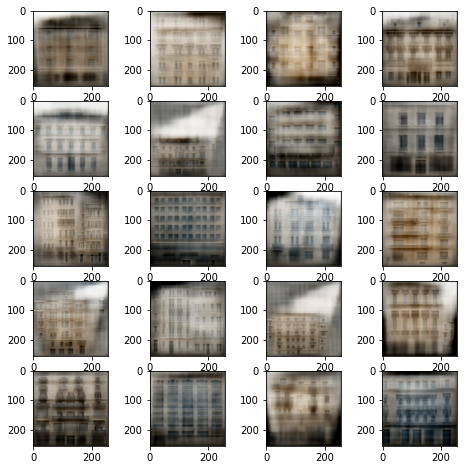

In [106]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, i)
    img = np.transpose(imgs[i].cpu().detach().numpy(), [1, 2, 0])
    plt.imshow(np.clip(img, 0, 1))
plt.show()